In [1]:
import gc
# import tensorflow as tf
import numpy as np
import cv2
import time
from grabscreen import grab_screen
import matplotlib.pyplot as plt
import keyboard as kb
import datetime
import os
import pickle
from collections import deque, namedtuple
from scipy.signal import find_peaks

from utils import read_speed, read_angle, preprocess_img, IMG_SIZE_X, IMG_SIZE_Y, dls_from_np, angle_diff_norm

import timm
from fastai.vision.all import *
from fastai.vision.core import PILImage
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath


PATH = 'H:/machine learning/NFSMW_v1/images/test_angle_norot'

### MODEL TO PRODUCTION

In [2]:
dummy_x = np.empty(shape=(1, IMG_SIZE_Y, IMG_SIZE_X, 3), dtype=np.uint8)
dummy_y = np.empty(shape=(1, ))
dls = dls_from_np(dummy_x, dummy_y, num_train=1)

learn = vision_learner(dls, 'convnext_tiny_in22k', pretrained=True, n_out=4, cbs=GradientAccumulation(64), model_dir='models')
learn.load('convnext_tiny_kbinput')


screen = grab_screen(region=(1, 31, 1278, 668))
img = preprocess_img(screen)
learn.predict(img)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


((1.1411702632904053,
  0.011877067387104034,
  0.2773630917072296,
  0.5516160130500793),
 TensorBase([1.1412, 0.0119, 0.2774, 0.5516]),
 TensorBase([1.1412, 0.0119, 0.2774, 0.5516]))

In [3]:
def speed_loss(inp, speed, angle): return F.mse_loss(inp[:, 0], speed)
def angle_loss(inp, speed, angle): return F.mse_loss(inp[:, 1], angle)
def combine_loss(inp, speed, angle): return speed_loss(inp, speed, angle) + angle_loss(inp, speed, angle)

dummy_x = np.empty(shape=(1, IMG_SIZE_Y, IMG_SIZE_X, 3), dtype=np.uint8)
dummy_y = np.empty(shape=(1, ))
dls = dls_from_np(dummy_x, dummy_y, num_train=1)

learn = vision_learner(dls, 'convnext_small_in22k', pretrained=True, loss_func=combine_loss, metrics=(speed_loss, angle_loss), n_out=2, cbs=GradientAccumulation(64))
learn.load('convnext_small_8ep')

screen = grab_screen(region=(1, 31, 1278, 668))
img = preprocess_img(screen)
learn.predict(img)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


((0.6574746370315552, -0.09652049839496613),
 TensorBase([ 0.6575, -0.0965]),
 TensorBase([ 0.6575, -0.0965]))

In [ ]:
def speed_loss(inp, speed, angle): return F.mse_loss(inp[:, 0], speed)
def angle_loss(inp, speed, angle): return F.mse_loss(inp[:, 1], angle)
def combine_loss(inp, speed, angle): return speed_loss(inp, speed, angle) + angle_loss(inp, speed, angle)

dummy_x = np.empty(shape=(1, IMG_SIZE_Y, IMG_SIZE_X, 3), dtype=np.uint8)
dummy_y = np.empty(shape=(1, ))
dls = dls_from_np(dummy_x, dummy_y, num_train=1)

learn = load_learner('models/convnext_small_8ep.pkl')
learn.dls = dls

screen = grab_screen(region=(1, 31, 1278, 668))
img = preprocess_img(screen)
learn.predict(img)

In [4]:
dummy_x = np.empty(shape=(1, IMG_SIZE_Y, IMG_SIZE_X, 3), dtype=np.uint8)
dummy_y = np.empty(shape=(1, ))
dls = dls_from_np(dummy_x, dummy_y, num_train=1)
learn = vision_learner(dls, 'convnext_tiny_in22k', pretrained=True, model_dir='models')
learn.load('convnext_tiny_480pRGB2pack_regression_6ep')

screen = grab_screen(region=(1, 31, 1278, 668))
img = preprocess_img(screen)
learn.predict(img)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


((-4.9817047119140625,), TensorBase([-4.9817]), TensorBase([-4.9817]))

### READ/PREPROCESS/GET ANGLE DATA

In [ ]:
from datetime import datetime, timedelta

TIME_LIMIT = 1.1
TIME_OFFSET = 0.5


SRC_PATH = '../input/nfsmw'
Img = namedtuple('Img', 'track_id path time speed angle kb_input')

dataset = []
sum_images = 0


track_paths = [Path("images_uploadable/480pRGB/12"), Path("images_uploadable/480pRGB/13")]
VAL_TRACK_IDS = ['12']

for track_path in track_paths:
    queue = []
    track_id = track_path.name
    print(f"Starting {track_id}, {len(os.listdir(track_path))} images")
    sum_images += len(os.listdir(track_path))
    for img_name in sorted(os.listdir(track_path)):
        # READ RAW IMAGE
        img_path = os.path.join(track_path, img_name)
        # GET PROPERTIES / PREPROCESS
        features = img_name.split('_')
        img = Img(
            track_id = track_id,
            path=img_path,
            time=datetime.strptime(features[0], "%Y-%m-%d-%H-%M-%S-%f"),
            speed=int(features[1]),
            angle=int(features[2]),
            kb_input=features[3]
            )

        # ADD TO QUEUE AWITING FOR FUTURE ANGLE DATA
        queue.append(img)
        while img.time - queue[0].time > timedelta(seconds=TIME_LIMIT):
            queue.pop(0)
        if img.time - queue[0].time < timedelta(seconds=TIME_OFFSET):
            continue

        # GET SPEED/ANGLE DIFF
        img = queue.pop(0)
        speed_diff = queue[-1].speed - img.speed
        future_angle = queue[-1].angle

        angle_diff = angle_diff_norm(future_angle - img.angle)

        # ADD TO DATASET
        dataset.append({
            'img_path': img.path, 
            'speed': img.speed,
            'speed_diff': speed_diff, 
            'angle_diff': angle_diff,
            'track_id': track_id
        })
print(f'\nPreprocessed {sum_images} images in total')

def get_dls_from_df(dataset):
    dataset = pd.DataFrame.from_dict(dataset)
    dataset.drop(dataset[(dataset['speed'] <= 70) & (dataset['speed_diff'] <= 5)].index, inplace=True)
    dataset.drop(dataset[dataset['speed_diff'] <= -50].index, inplace=True)
    dataset['speed_diff'] = np.tanh(dataset['speed_diff']+10)

    dblock = DataBlock(
        blocks=(ImageBlock, RegressionBlock, RegressionBlock),
        get_x=Pipeline(ColReader('img_path'), get_image_files),
        get_y=(ColReader('speed_diff'), ColReader('angle_diff')),
        splitter=ColSplitter('track_id', VAL_TRACK_IDS),
        n_inp=1
        )

    dls = dblock.dataloaders(dataset, shuffle=True, bs=64)
    return dls
    # dls.show_batch()
dls = get_dls_from_df(dataset)
dls.dataset

In [ ]:
q = pd.DataFrame.from_dict([{
    'img_path': 'H:/machine learning/NFSMW_v1/dummy_img.png', 
    'speed': 123,
    'speed_diff': 4,
    'angle_diff': 1,
    'track_id': 12
}])
dls = get_dls_from_df(q)
dls.dataset

In [ ]:
def speed_loss(inp, speed, angle): return F.mse_loss(inp[:, 0], speed)
def angle_loss(inp, speed, angle): return F.mse_loss(inp[:, 1], angle)
def combine_loss(inp, speed, angle): return speed_loss(inp, speed, angle) + angle_loss(inp, speed, angle)

learn = load_learner('models/convnext_small_5ep_deafultarch-logp10.pkl')

screen = grab_screen(region=(1, 31, 1278, 668))
img = preprocess_img(screen)

# # img = np.moveaxis(img, -1, 0)
# img_fastai = Image(pil2tensor(img, dtype=np.float32)).div_(255)
# print(type(img_fastai))
pred = learn.predict(img)

In [ ]:
def speed_loss(inp, speed, angle): return F.mse_loss(inp[:, 0], speed)
def angle_loss(inp, speed, angle): return F.mse_loss(inp[:, 1], angle)
def combine_loss(inp, speed, angle): return speed_loss(inp, speed, angle) + angle_loss(inp, speed, angle)

learn = load_learner('models/convnext_small_5ep_deafultarch-logp10.pkl')

screen = grab_screen(region=(1, 31, 1278, 668))
img = preprocess_img(screen)

# # img = np.moveaxis(img, -1, 0)
# img_fastai = Image(pil2tensor(img, dtype=np.float32)).div_(255)
# print(type(img_fastai))
pred = learn.predict(img)
# pred
# learn.get_preds(dl=DataLoader(img[None]))
# qwe = PILImage.create(img)
# qwe.show
# learn.predict(PILImage.create(img))
# learn.predict(np.empty((270, 480, 3), dtype='uint8'))
# learn.predict('dummy_img.png')

In [ ]:
input = torch.randn(2)
m = F.gelu(input, approximate='tanh'); m

In [ ]:
list(learn.children())[3]

In [ ]:
import timm
from fastai.vision.all import *

# torch.cuda.is_available()
learn = vision_learner(dls, 'convnext_tiny_in22k', pretrained=True, model_dir='')
# learn = timm.create_model('convnext_tiny_in22k')
# learn.eval()
# learn.default_cfg
learn.summary()

In [ ]:
# sum = 0
# for i in range(100):
#     t_start = time.perf_counter()
#     screen = grab_screen(region=(1, 31, 1278, 668))
#     t_stop = time.perf_counter()
#     diff = t_stop - t_start
#     sum += diff
#     print("Czas obliczeń:", "{:.7f}".format(diff))
# print(sum)


### READ ANGLE

In [ ]:
# FHD VERSION
# MIN_Y, MIN_X = (853, 191); MIN_R = 20
# HD VERSION
MIN_Y, MIN_X = (528, 127); MIN_R = 15

def read_angle(img):
    img = cv2.imread(r"H:\machine learning\NFSMW_v1\images\handmade\20/2022-08-25-14-02-29-411_1001.png", cv2.IMREAD_GRAYSCALE)
    minimap = img[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]

    minimap = (minimap > 50).astype(np.uint8)

    # marker = cv2.floodFill(minimap, mask=np.zeros((2*MIN_R+2, 2*MIN_R+2), dtype=np.uint8), seedPoint=(MIN_R, MIN_R), newVal=255)
    cv2.floodFill(minimap, mask=None, seedPoint=(MIN_R, MIN_R), newVal=255)


    plt.figure()
    plt.imshow(minimap, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

    edges = cv2.Canny(minimap, 0, 1000)







    minimap = cv2.linearPolar(minimap, (MIN_R, MIN_R), 20, cv2.WARP_FILL_OUTLIERS)


    plt.figure()
    plt.imshow(minimap, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

    end_of_line = -np.argmin(minimap, axis=1)
    end_of_line = np.append(end_of_line, -minimap.shape[0])
    # end_of_line = np.append(end_of_line, end_of_line[:10])
    # end_of_line = np.array([sum(np.take(end_of_line, range(i-5, i+6), mode='wrap')) for i in range(end_of_line.shape[0])])
    peaks_idx = find_peaks(end_of_line)[0]
    peaks_val =  -np.take(end_of_line, peaks_idx)
    try:
        angle = peaks_idx[np.argmax(peaks_val)]
        return angle
    except:
        return 0

read_angle(None)

In [ ]:
eps = 0.03
len_hist = 4
eps_hist = 2
history = deque([0 for _ in range(len_hist)], maxlen=len_hist)

screen = grab_screen(region=(1, 31, 1278, 668))
initial_angle = read_angle(screen)
desired_angle = initial_angle + 2
for i in range(2, 0, -1):
    print(i)
    time.sleep(1)       
while True:
    t_start = time.perf_counter()

    screen = grab_screen(region=(1, 31, 1278, 668))
    angle = read_angle(screen)
    # diff = np.abs(initial_angle - angle)
    diff = angle - initial_angle
    initial_angle = angle
    if diff > eps:
        print(f'LEFT ', end=' ')
        history.append(1)
    elif diff < -eps:
        print(f'RIGHT', end=' ')
        history.append(-1)
    else:
        print('     ', end=' ')
        history.append(0)
 
    pred = sum(history)
    if pred >= eps_hist:
        print(f'LEFT_ ', end=' ')
    elif pred <= -eps_hist:
        print(f'RIGHT_', end=' ')
    else:
        print('     ', end=' ')

    # time.sleep(0.1)
    t_stop = time.perf_counter()
    # print("", "{:.2f}".format(t_stop - t_start), end=' ')

    print('', end='\r')

### READ SPEED

In [ ]:
AREAS = [
    (1, 8),
    (6, 1),
    (6, 15),
    (11, 8),
    (18, 1),
    (18, 15),
    (23, 8),
]

def get_digit(img): # 25x17
    res = np.zeros(7, dtype=bool)
    for it, (x, y) in enumerate(AREAS):
        if np.any(img[x-1:x+2, y-1:y+2]):
            res[it] = True
 
    if   np.all(res == np.array([False, False, False, False, False, False, False])):
        return 0
    elif np.all(res == np.array([True,  True,  True,  False, True,  True,  True ])):
        return 0
    elif np.all(res == np.array([False, False, True,  False, False, True,  False])):
        return 1
    elif np.all(res == np.array([True,  False, True,  True,  True,  False, True ])):
        return 2
    elif np.all(res == np.array([True,  False, True,  True,  False, True,  True ])):
        return 3
    elif np.all(res == np.array([False, True,  True,  True,  False, True,  False])):
        return 4
    elif np.all(res == np.array([True,  True,  False, True,  False, True,  True ])):
        return 5
    elif np.all(res == np.array([True,  True,  False, True,  True,  True,  True ])):
        return 6
    elif np.all(res == np.array([True,  False, True,  False, False, True,  False])):
        return 7
    elif np.all(res == np.array([True,  True,  True,  True,  True,  True,  True ])):
        return 8
    elif np.all(res == np.array([True,  True,  True,  True,  False, True,  True ])):
        return 9
    else:
        return 1000

# for _ in range(30):
#     idx = np.random.randint(0, 349)
#     # print(idx)
#     img_name = os.listdir(PATH)[idx]
#     img = cv2.imread(os.path.join(PATH, img_name), cv2.IMREAD_GRAYSCALE)

#     img = img[555:580, 1117:1185]
#     img = img < 40
#     dig1 = img[:, :17]
#     dig2 = img[:, 25:25+17]
#     dig3 = img[:, 51:51+17]

#     plt.figure(figsize=(5, 5))
#     plt.imshow(img, cmap='gray')
#     plt.xticks([]), plt.yticks([])
#     plt.show()

#     speed = 100*get_digit(dig1) + 10*get_digit(dig2) + 1*get_digit(dig3)
#     print(speed)

In [54]:
# FOR 720P


AREAS = [
    (1, 8),
    (6, 1),
    (6, 15),
    (11, 8),
    (18, 1),
    (18, 15),
    (23, 8),
]
def get_digit(screen): # 25x17
    display = np.zeros(7, dtype=bool)
    for it, (x, y) in enumerate(AREAS):
        if np.any(screen[x-1:x+2, y-1:y+2]):
            display[it] = True
 
    if   np.all(display == np.array([False, False, False, False, False, False, False])):
        return 0
    elif np.all(display == np.array([True,  True,  True,  False, True,  True,  True ])):
        return 0
    elif np.all(display == np.array([False, False, True,  False, False, True,  False])):
        return 1
    elif np.all(display == np.array([True,  False, True,  True,  True,  False, True ])):
        return 2
    elif np.all(display == np.array([True,  False, True,  True,  False, True,  True ])):
        return 3
    elif np.all(display == np.array([False, True,  True,  True,  False, True,  False])):
        return 4
    elif np.all(display == np.array([True,  True,  False, True,  False, True,  True ])):
        return 5
    elif np.all(display == np.array([True,  True,  False, True,  True,  True,  True ])):
        return 6
    elif np.all(display == np.array([True,  False, True,  False, False, True,  False])):
        return 7
    elif np.all(display == np.array([True,  True,  True,  True,  True,  True,  True ])):
        return 8
    elif np.all(display == np.array([True,  True,  True,  True,  False, True,  True ])):
        return 9
    else:
        return 1000

def read_speed(screen):
    screen = screen[598:625, 1119:1187]
    screen = screen < 40


    dig1 = screen[:, :18]
    dig2 = screen[:, 26:26+18]
    dig3 = screen[:, 50:50+18]
    return 100*get_digit(dig1) + 10*get_digit(dig2) + 1*get_digit(dig3)



sc1 = cv2.imread('images/tests/test_angle_720p/fast/2022-10-10-13-49-16-810_11700_165.19777462699756_0001_.png', cv2.IMREAD_GRAYSCALE)
# sc2 = cv2.imread('H:/machine learning/NFSMW_v1/images/test_angle_pt2.png', cv2.IMREAD_GRAYSCALE)


print(read_speed(sc1))

# plt.figure()
# plt.imshow(sc1, cmap='gray')
# plt.xticks([]), plt.yticks([])
# plt.show()

18


### READ ANGLE

In [ ]:
for _ in range(1):
    # idx = np.random.randint(0, 600)
    # idx = 113
    # print(idx)
    def cut_minimap(idx):
        img_name = os.listdir(PATH)[idx]
        img = cv2.imread(os.path.join(PATH, img_name), cv2.IMREAD_GRAYSCALE)
        speed = read_speed(img)
        if speed >= 1000:
            print(speed)
        y = np.array(list(img_name[-8:-4]), dtype=int)

        # img = preprocess_img(img)
        # img = tf.keras.utils.normalize(img)
        # img = tf.convert_to_tensor(img, dtype=tf.float32)

        MIN_Y, MIN_X = (529, 128)
        MIN_R = 98
        minimap = img[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]

        



        # plt.figure()
        # plt.imshow(minimap, cmap='gray')
        # plt.xticks([]), plt.yticks([])
        # # plt.title(f'{acceleration + direction}; {y}')
        # plt.show()


        mask = np.zeros(minimap.shape, dtype="uint8")
        mask = cv2.circle(mask, (MIN_R,MIN_R), int(0.7*MIN_R), (255,255,255), -1)
        mask_vehicle = np.zeros(minimap.shape, dtype="uint8")
        mask_vehicle = cv2.circle(mask_vehicle, (MIN_R,MIN_R), 7, (255,255,255), -1)
        mask = cv2.subtract(mask, mask_vehicle)

        minimap = cv2.bitwise_and(minimap, minimap, mask=mask)
        # minimap = minimap >= 180

        # img = np.array(img).reshape(1, IMG_SIZE_Y, IMG_SIZE_X, 1)


        plt.figure()
        plt.imshow(minimap, cmap='gray')
        plt.xticks([]), plt.yticks([])
        # plt.title(f'{acceleration + direction}; {y}')
        plt.show()

        polar = cv2.linearPolar(minimap, (MIN_R, MIN_R), int(0.7*MIN_R), cv2.WARP_FILL_OUTLIERS)
        polar = polar >= 150
        plt.figure()
        plt.imshow(polar, cmap='gray')
        plt.xticks([]), plt.yticks([])
        # plt.title(f'{acceleration + direction}; {y}')
        plt.show()

        # print(polar.sum(axis=1))
        print(np.average([i for i in range(polar.shape[0])], weights=polar.sum(axis=1)))

    # images/41
    # cut_minimap(115)
    # cut_minimap(118)
    # cut_minimap(120)

    # cut_minimap(425)
    # cut_minimap(426)

    # cut_minimap(428)
    # cut_minimap(429)
    # cut_minimap(430)

    for i in range(120, 146):
        cut_minimap(i)

In [ ]:
for _ in range(1):
    # idx = np.random.randint(0, 600)
    # idx = 113
    # print(idx)
    def cut_minimap_norotation(idx):
        img_name = os.listdir(PATH)[idx]
        img = cv2.imread(os.path.join(PATH, img_name), cv2.IMREAD_GRAYSCALE)
        speed = read_speed(img)
        if speed >= 1000:
            print(speed)
        y = np.array(list(img_name[-8:-4]), dtype=int)

        # img = preprocess_img(img)
        # img = tf.keras.utils.normalize(img)
        # img = tf.convert_to_tensor(img, dtype=tf.float32)

        MIN_Y, MIN_X = (529, 128)
        MIN_R = 98
        minimap = img[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]

        



        # plt.figure()
        # plt.imshow(minimap, cmap='gray')
        # plt.xticks([]), plt.yticks([])
        # # plt.title(f'{acceleration + direction}; {y}')
        # plt.show()


        # mask = np.zeros(minimap.shape, dtype="uint8")
        # mask = cv2.circle(mask, (MIN_R,MIN_R), int(0.7*MIN_R), (255,255,255), -1)
        mask_vehicle = np.zeros(minimap.shape, dtype="uint8")
        mask_vehicle = cv2.circle(mask_vehicle, (MIN_R,MIN_R), 12, (255,255,255), -1)
        # mask = cv2.subtract(mask, mask_vehicle)

        minimap = cv2.bitwise_and(minimap, minimap, mask=mask_vehicle)
        # minimap = minimap >= 200

        # img = np.array(img).reshape(1, IMG_SIZE_Y, IMG_SIZE_X, 1)


        plt.figure()
        plt.imshow(minimap, cmap='gray')
        plt.xticks([]), plt.yticks([])
        # plt.title(f'{acceleration + direction}; {y}')
        plt.show()

        plt.figure()
        plt.imshow(minimap == 203, cmap='gray')
        plt.xticks([]), plt.yticks([])
        # plt.title(f'{acceleration + direction}; {y}')
        plt.show()

        polar = cv2.linearPolar(minimap, (MIN_R, MIN_R), 12, cv2.WARP_FILL_OUTLIERS)
        polar = polar >= 198
        plt.figure()
        plt.imshow(polar, cmap='gray')
        plt.xticks([]), plt.yticks([])
        # plt.title(f'{acceleration + direction}; {y}')
        plt.show()

        # print(polar.sum(axis=1))
        print(np.average([i for i in range(polar.shape[0])], weights=polar.sum(axis=1)))

    # images/41
    cut_minimap_norotation(50)
    cut_minimap_norotation(60)
    cut_minimap_norotation(90)
    # cut_minimap(118)
    # cut_minimap(120)

    # cut_minimap(425)
    # cut_minimap(426)

    # cut_minimap(428)
    # cut_minimap(429)
    # cut_minimap(430)

    # for i in range(120, 146):
    #     cut_minimap(i)

In [ ]:
model = tf.keras.models.load_model('alex_dir_100k_3epoch.model')
# model.summary()

### TEST PREDICTIONS [TF]

In [ ]:
PATH = 'H:/machine learning/NFSMW_v1/images/handmade/41'
# PATH = 'H:/machine learning/NFSMW_v1/images/bot_x3speed/20'
for _ in range(30):
    img_name = os.listdir(PATH)[np.random.randint(0, 600)]
    img = cv2.imread(os.path.join(PATH, img_name), cv2.IMREAD_GRAYSCALE)
    speed = read_speed(img)
    if speed >= 1000:
        print(speed)
    y = np.array(list(img_name[-8:-4]), dtype=int)[2:]
    # y = img_name.split('_')[-3]

    img = preprocess_img(img)
    img = img / 255.0
    img = np.array(img).reshape(1, IMG_SIZE_Y, IMG_SIZE_X, 1)

    tf.keras.backend.clear_session()
    gc.collect()
    output = model({'img': img, 'speed': np.array([speed])}).numpy()[0]
    tf.keras.backend.clear_session()
    gc.collect()

    # direction, acceleration = output[0].numpy()[0], output[1].numpy()[0]
    # direction =  CONVERT_INPUT[np.argmax(direction)]
    # acceleration =  CONVERT_INPUT[np.argmax(acceleration)]

    plt.figure()
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title(f'{output}; {y}')
    plt.show()

In [ ]:
import pandas as pd
PATH = r"H:\machine learning\NFSMW_v1\images\test_x2gamespeed_bot"
real = []
read = []
for img_name in os.listdir(PATH):
    params = img_name.split('_')
    input = params[-3][2:]
    predicted = params[-2]
    
    if input == '10':
        real.append('left')
    elif input == '01':
        real.append('right')
    else:
        real.append('straight')

    read.append(predicted)

df = pd.DataFrame({'real': real, 'read': read})
df['read'] = df.read.shift(-2)

### MINIMAP ROTATION

In [ ]:
from grabscreen import grab_screen

# FHD VERSION
# MIN_Y, MIN_X = (853, 191); MIN_R = 20
# HD VERSION
MIN_Y, MIN_X = (528, 127); MIN_R = 15

prev_angle = 0
def read_angle(screen):
    minimap = screen[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]
    # minimap = cv2.imread('H:/machine learning/NFSMW_v1/images/test_minimap_norot.png', cv2.IMREAD_COLOR)

    # minimap = cv2.resize(minimap, (3*MIN_R, 3*MIN_R))
    
    # minimap = cv2.GaussianBlur(minimap, (5, 5), 0)

    plt.figure()
    plt.imshow(minimap, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()


    plt.figure()
    plt.imshow(minimap[:, :, 2] > 230, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()



    minimap = cv2.linearPolar(minimap, (MIN_R, MIN_R), 20, cv2.WARP_FILL_OUTLIERS)
    minimap = minimap[:, :, 2] > 230


    plt.figure()
    plt.imshow(minimap, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

    end_of_line = -np.argmin(minimap, axis=1)
    end_of_line = np.append(end_of_line, -minimap.shape[0])
    # end_of_line = np.append(end_of_line, end_of_line[:10])
    # end_of_line = np.array([sum(np.take(end_of_line, range(i-5, i+6), mode='wrap')) for i in range(end_of_line.shape[0])])
    peaks_idx = find_peaks(end_of_line)[0]
    peaks_val =  -np.take(end_of_line, peaks_idx)
    try:
        angle = peaks_idx[np.argmax(peaks_val)]
        return angle
    except:
        return 0

from IPython.display import clear_output

# while True:
for _ in range(1):
    clear_output(wait=True)
    # screen = grab_screen(region=(0, 31, 1920, 1080))
    screen = grab_screen(region=(1, 31, 1278, 668))
    angle = read_angle(screen)
    print(angle, end='\r')


In [ ]:
from grabscreen import grab_screen
from utils import read_angle
COUNT_EDGES = [0]*10

# FHD VERSION
# MIN_Y, MIN_X = (853, 191); MIN_R = 20
# HD VERSION
MIN_Y, MIN_X = (528, 127); MIN_R = 15

prev_angle = 0
def read_angle_byHoughLines(screen, show_all=False):
    minimap = screen[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]
    minimap = (minimap > 60).astype(np.uint8)
    cv2.floodFill(minimap, mask=None, seedPoint=(MIN_R, MIN_R), newVal=255)

    result = minimap.copy()
    edges = cv2.Canny(minimap, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/360, 12, minLineLength=8, maxLineGap=10)

    global COUNT_EDGES
    if lines is None:
        COUNT_EDGES[0] += 1
        return

    i = 0
    for tpl in lines:
        for x1,y1,x2,y2 in tpl:
            i+=1
            cv2.line(result,(x1,y1),(x2,y2),(70,0,0),1)
                
    COUNT_EDGES[i] += 1

    angles = [np.arctan((tpl[0][1]-tpl[0][3]) / (tpl[0][2]-tpl[0][0]))*180/np.pi for tpl in lines]
    angles = list(set(angles))
    print(angles)

    if len(angles) == 3:
        a0 = np.abs(np.abs(angles[1] - angles[2]) - 40)
        a1 = np.abs(np.abs(angles[0] - angles[2]) - 40)
        a2 = np.abs(np.abs(angles[0] - angles[1]) - 40)
        del angles[np.argmin([a0, a1, a2])]
        print(angles)

    if len(angles) == 2:
        result_angle = sum(angles) / 2
        # if np.abs(angles[0] - angles[1]) > 90:
        #     result_angle += 90
        print(result_angle)

    print(read_angle(screen))

    plt.figure(figsize=(3, 3))
    plt.imshow(result, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()



SRC_PATH = 'H:/machine learning/NFSMW_v1/images/handmade_480pRGB'
# track_ids = range(33, 40)
track_ids = [37]
for track_id in track_ids:
    for img_name in os.listdir(os.path.join(SRC_PATH, str(track_id)))[100:250]:
        img = cv2.imread(os.path.join(SRC_PATH, str(track_id), img_name), cv2.IMREAD_GRAYSCALE)
        read_angle_byHoughLines(img)
        

print(COUNT_EDGES)

[-122.47119229084844, -167.00538320808337]
-144.7382877494659


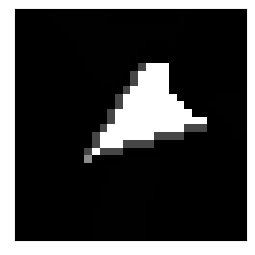

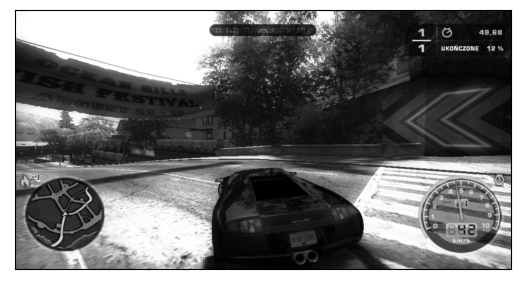

[-168.69006752597983, -123.69006752597984]
-146.19006752597983


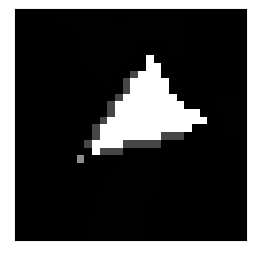

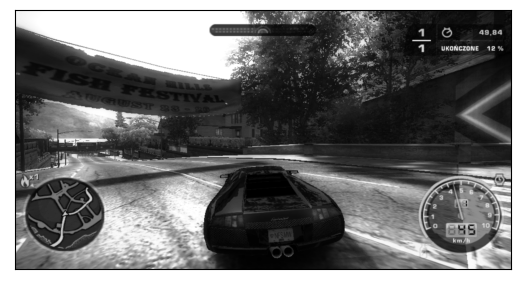

In [12]:
from grabscreen import grab_screen
from utils import read_angle
COUNT_EDGES = [0]*10
RESULTS = np.zeros((30, 30), dtype=np.uint8)

# FHD VERSION
# MIN_Y, MIN_X = (853, 191); MIN_R = 20
# HD VERSION
MIN_Y, MIN_X = (528, 127); MIN_R = 15

Line = namedtuple('Line', 'x1 y1 x2 y2 angle')

def read_angle_byHoughLines(screen, show_all=False):
    # get and preprocess minimap
    minimap = screen[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]
    minimap = (minimap > 60).astype(np.uint8)
    cv2.floodFill(minimap, mask=None, seedPoint=(MIN_R, MIN_R), newVal=255)
    # find edges and lines corresponding to them
    edges = cv2.Canny(minimap, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/360, 12, minLineLength=8, maxLineGap=10)
    
    #draw lines (debug purposes) 
    for tpl in lines:
        for x1,y1,x2,y2 in tpl:
            cv2.line(minimap,(x1,y1),(x2,y2),(70,0,0),1)
                
    # track number of lines found (to del)
    global COUNT_EDGES
    if lines is None:
        COUNT_EDGES[0] += 1
        return
    COUNT_EDGES[len(lines)] += 1

    lines = [Line(x1=x1, y1=y1, x2=x2, y2=y2, angle=-np.arctan2((y2-y1), (x2-x1))*180/np.pi) for tpl in lines for x1,y1,x2,y2 in tpl]
    
    
    # print(lines)
    
    # angles = [np.arctan((tpl[0][1]-tpl[0][3]) / (tpl[0][2]-tpl[0][0]))*180/np.pi for tpl in lines]
    # angles = [np.arctan((tpl[0][1]-tpl[0][3]) / (tpl[0][2]-tpl[0][0]))*180/np.pi for tpl in lines]
    # angles = list(set(angles))

    # delete third line corresponding to base
    if len(lines) == 3:
        a0 = np.abs(np.abs(lines[1].angle - lines[2].angle) - 40)
        a1 = np.abs(np.abs(lines[0].angle - lines[2].angle) - 40)
        a2 = np.abs(np.abs(lines[0].angle - lines[1].angle) - 40)
        del lines[np.argmin([a0, a1, a2])]

    if len(lines) == 2:
        # find intersection point - from general equaiton ax + by + c = 0
        a1, a2 = ((line.y2-line.y1) / (line.x2-line.x1) if (line.x2-line.x1) != 0 else 1000 for line in lines)
        b1, b2 = -1, -1
        c1, c2 = lines[0].y1 - a1 * lines[0].x1, lines[1].y1 - a2 * lines[1].x1

        if (a1*b2 - a2*b1) == 0:
            return
        x = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
        y = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)



        try:
            minimap[np.rint(y).astype(int), np.rint(x).astype(int)] = 140
            RESULTS[np.rint(y).astype(int), np.rint(x).astype(int)] = 255
        except:
            print(x, y)

        # angles = [np.arctan2(-(line.y1-y), (line.x1-x))*180/np.pi for line in lines]
        angles = [-np.arctan2(-(line.y1-y), -(line.x1-x))*180/np.pi for line in lines]
        print(angles)

        if angles[0] * angles[1] < 0:
            if np.abs(angles[0] - angles[1]) > 180:
                angles[np.argmin(angles)] += 360
            # else:
                

        result_angle = np.mean(angles)

        if result_angle > 180:
            result_angle -= 360
        #     if np.abs(angles[0] - angles[1]) > 180:
        #         result_angle -= 180
        #     else:

        print(result_angle)

    # print(read_angle(screen))

    plt.figure(figsize=(3, 3))
    plt.imshow(minimap, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()



# SRC_PATH = 'H:/machine learning/NFSMW_v1/images/handmade_480pRGB'
# # track_ids = range(33, 40)
# track_ids = [37]
# for track_id in track_ids:
#     for img_name in os.listdir(os.path.join(SRC_PATH, str(track_id)))[100:300]:
#         img = cv2.imread(os.path.join(SRC_PATH, str(track_id), img_name), cv2.IMREAD_GRAYSCALE)
#         read_angle_byHoughLines(img)
        

# print(COUNT_EDGES)
# plt.figure(figsize=(3, 3))
# plt.imshow(RESULTS, cmap='gray')
# plt.xticks([]), plt.yticks([])
# plt.show()

##############

sc1 = cv2.imread('H:/machine learning/NFSMW_v1/images/test_angle_pt1.png', cv2.IMREAD_GRAYSCALE)
sc2 = cv2.imread('H:/machine learning/NFSMW_v1/images/test_angle_pt2.png', cv2.IMREAD_GRAYSCALE)


read_angle_byHoughLines(sc1)

plt.figure()
plt.imshow(sc1, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

read_angle_byHoughLines(sc2)

plt.figure()
plt.imshow(sc2, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
sum_time = 0
for i in range(500):
    t_start = time.perf_counter()
    # _ = read_angle_byHoughLines(sc1)
    # _ = read_angle_byHoughLines(sc2)
    t_stop = time.perf_counter()
    diff = t_stop - t_start
    sum_time += diff
    # print("Czas obliczeń:", "{:.7f}".format(diff))
print(sum_time)


In [ ]:
# FHD VERSION
# MIN_Y, MIN_X = (853, 191); MIN_R = 20
# HD VERSION
MIN_Y, MIN_X = (528, 127); MIN_R = 15

def read_angle_4points(screen):
    minimap = screen[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]
    minimap = cv2.cvtColor(minimap, cv2.COLOR_RGB2GRAY)
    minimap = (minimap > 60).astype(np.uint8)
    cv2.floodFill(minimap, mask=None, seedPoint=(MIN_R, MIN_R), newVal=255)
    minimap[minimap==1] = 0

    y, x = np.where(minimap>0)
    # print(y, x)
    top   = (min(y), int(np.mean(x[y==min(y)])))
    bot   = (max(y), int(np.mean(x[y==max(y)])))
    left  = (int(np.mean(y[x==min(x)])), min(x))
    right = (int(np.mean(y[x==max(x)])), max(x))
    
    points = (top, bot, left, right)
    for y, x in points:
        minimap[y, x] = 150
    
    distance = np.ones((4, 4), dtype=np.uint8) * np.inf
    for row, src in enumerate(points):
        for col, dst in enumerate(points):
            if row >= col:
                continue
            distance[row, col] = np.sum([(src[i] - dst[i])**2 for i in range(2)])

    print(distance)
    ver, hor = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
    p1, p2 = points[int(ver==0)], points[int(hor==2)+2]
    
    minimap[p1] = 70
    minimap[p2] = 70
    
    plt.figure()
    plt.imshow(minimap, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()


sc1 = cv2.imread('H:/machine learning/NFSMW_v1/images/test_angle_pt1.png', cv2.IMREAD_COLOR)
sc2 = cv2.imread('H:/machine learning/NFSMW_v1/images/test_angle_pt2.png', cv2.IMREAD_COLOR)


SRC_PATH = 'H:/machine learning/NFSMW_v1/images/handmade_480pRGB'
# track_ids = range(33, 40)
track_ids = [33]
for track_id in track_ids:
    for img_name in os.listdir(os.path.join(SRC_PATH, str(track_id)))[:200]:
        img = cv2.imread(os.path.join(SRC_PATH, str(track_id), img_name))#, cv2.IMREAD_GRAYSCALE)
        read_angle_4points(img)
# read_angle_4points(sc2)

### NEW SCREEN CAPTURE

In [14]:
from window_capture import WindowCapture

wincap = WindowCapture('Need for Speed™ Most Wanted')

img = wincap.get_screenshot()

MIN_Y, MIN_X = (569, 128); MIN_R = 16
minimap = img[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]

plt.figure()
plt.imshow(cv2.cvtColor(minimap, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

cv2.imwrite('test_wincapture.png', img)

error: CreateCompatibleDC failed

In [5]:
from utils import Line
from IPython.display import clear_output
from window_capture import WindowCapture

# FHD VERSION
# MIN_Y, MIN_X = (853, 191); MIN_R = 20
# HD VERSION
MIN_Y, MIN_X = (528, 127); MIN_R = 15
# 960x540p VERSION
# MIN_Y, MIN_X = (427, 96); MIN_R = 10
# 1280x720 VERSION
# MIN_Y, MIN_X = (569, 128); MIN_R = 16

def read_angle_byHoughLines(screen):
    # get and preprocess minimap
    minimap = screen[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]
    minimap = (minimap > 60).astype(np.uint8)
    cv2.floodFill(minimap, mask=None, seedPoint=(MIN_R, MIN_R), newVal=255)
    
    # find edges and lines corresponding to them
    edges = cv2.Canny(minimap, 0, 150)
    #lines = cv2.HoughLinesP(edges, 1, np.pi/360, 12, minLineLength=8, maxLineGap=10)
    # TESTING
    qwe = False
    cont = False
    thr = 12
    for _ in range(5):
        lines = cv2.HoughLinesP(edges, 1, np.pi/360, thr, minLineLength=8, maxLineGap=5)
        if lines is None or len(lines) < 2:
            thr -= 1
        elif len(lines) == 2:
            cont = True
            break
        elif len(lines) == 3:
            lines_temp = [Line(x1=x1, y1=y1, x2=x2, y2=y2, angle=-np.arctan2((y2-y1), (x2-x1))*180/np.pi) for tpl in lines for x1,y1,x2,y2 in tpl]
            a0 = np.abs(np.abs(lines_temp[1].angle - lines_temp[2].angle) - 40)
            a1 = np.abs(np.abs(lines_temp[0].angle - lines_temp[2].angle) - 40)
            a2 = np.abs(np.abs(lines_temp[0].angle - lines_temp[1].angle) - 40)
            qwe = True
        elif len(lines) > 2:
            thr += 1
    if not cont:
        # print('not found method')
        return

    if qwe:
        del lines[np.argmin([a0, a1, a2])]
    # END TESTING

    # lines = cv2.HoughLinesP(edges, 1, np.pi/360, 9, minLineLength=6, maxLineGap=10)
    # DEBUG - DRAW LINES
    if lines is None:
        print('NO LINES FOUND')
        return
    minimap_debug = minimap.copy()
    for tpl in lines:
        for x1,y1,x2,y2 in tpl:
            cv2.line(minimap_debug,(x1,y1),(x2,y2),(70,0,0),1)    
    # END DEBUG 
    lines = [Line(x1=x1, y1=y1, x2=x2, y2=y2, angle=-np.arctan2((y2-y1), (x2-x1))*180/np.pi) for tpl in lines for x1,y1,x2,y2 in tpl]

    # delete third line corresponding to base (if exists)
    if len(lines) == 3:
        print('CORRECTING LINES 3')
        a0 = np.abs(np.abs(lines[1].angle - lines[2].angle) - 40)
        a1 = np.abs(np.abs(lines[0].angle - lines[2].angle) - 40)
        a2 = np.abs(np.abs(lines[0].angle - lines[1].angle) - 40)
        del lines[np.argmin([a0, a1, a2])]

    if len(lines) != 2:
        print(f'NOT ENOUGH LINES; {len(lines)}')
        return None
    
    # find intersection point - from general equaiton ax + by + c = 0
    a1, a2 = ((line.y2-line.y1) / (line.x2-line.x1) if (line.x2-line.x1) != 0 else 1000 for line in lines)
    b1, b2 = -1, -1
    c1, c2 = lines[0].y1 - a1 * lines[0].x1, lines[1].y1 - a2 * lines[1].x1

    if (a1*b2 - a2*b1) == 0:
        print('PARALELL LINES')
        return None

    x = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
    y = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)

    try:
        # minimap[np.rint(y).astype(int), np.rint(x).astype(int)] = 140
        minimap_debug[np.rint(y).astype(int), np.rint(x).astype(int)] = 120
        minimap_debug[np.rint(lines[0].y1).astype(int), np.rint(lines[0].x1).astype(int)] = 160
        minimap_debug[np.rint(lines[1].y1).astype(int), np.rint(lines[1].x1).astype(int)] = 160
        # RESULTS[np.rint(y).astype(int), np.rint(x).astype(int)] = 255
    except:
        # plt.figure(figsize=(3, 3))
        # plt.imshow(minimap_debug, cmap='gray')
        # plt.xticks([]), plt.yticks([])
        # plt.show()
        # print('INTERSECTION POINT OUT OF MINIMAP')
        return None
    # for line in lines:
    #     line.x1 -= x; line.x2 -= x
    #     line.y1 -= y; line.y2 -= y

    # angles = [-np.arctan2(-(line.y1-y), -(line.x1-x))*180/np.pi for line in lines]
    # angles = np.array([np.arctan2(-(line.y1-y), line.x1-x) for line in lines]) * 180/np.pi
    angles = np.array([np.arctan2(-(line.y1-y), line.x1-x) if (line.x1-x)**2 + (line.y1-y)**2 > (line.x2-x)**2 + (line.y2-y)**2 else np.arctan2(-(line.y2-y), line.x2-x) for line in lines]) * 180/np.pi
    # DEBUG
    # plt.figure(figsize=(3, 3))
    # plt.imshow(minimap_debug, cmap='gray')
    # plt.xticks([]), plt.yticks([])
    # plt.show()
    # print(angles)
    # END DEBUG

    if np.abs(angles[0] - angles[1]) > 180:
        angles[np.argmin(angles)] += 360

    result_angle = np.mean(angles)

    if result_angle > 180:
        result_angle -= 360

    return result_angle


wincap = WindowCapture('Need for Speed™ Most Wanted')
MIN_Y, MIN_X = (569, 128); MIN_R = 16
while True:
# for _ in range(1):
    t_start = time.perf_counter()
    clear_output(wait=True)
    screen = wincap.get_screenshot()
    minimap = screen[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]
    # plt.figure()
    # plt.imshow(cv2.cvtColor(minimap, cv2.COLOR_BGR2RGB))
    # plt.xticks([]), plt.yticks([])
    # plt.show()
    print(read_angle_byHoughLines(cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)))
    t_stop = time.perf_counter()
    print(f'{(t_stop - t_start)*1000:.0f} ms')


# SRC_PATH = 'H:/machine learning/NFSMW_v1/images/handmade_480pRGB'
# # track_ids = range(33, 40)
# track_ids = [37]
# for track_id in track_ids:
#     for img_name in os.listdir(os.path.join(SRC_PATH, str(track_id)))[100:250]:
#         img = cv2.imread(os.path.join(SRC_PATH, str(track_id), img_name), cv2.IMREAD_GRAYSCALE)
#         # img = cv2.resize(img, (960, 540))
#         print(read_angle_byHoughLines(img))


def diff_angle_norm(this_angle, prev_angle):
    if np.abs(this_angle - prev_angle) > 180:
        if this_angle < 0:
            this_angle += 360
        else:
            prev_angle += 360
    diff = this_angle - prev_angle
    if abs(diff) > 30:
        return 40
    return diff

prev_angle = 0
none_ctr = 0
angle_diffs = []
# SRC_PATH = 'H:/machine learning/NFSMW_v1/images/tests/test_angle_720p/slow'
SRC_PATH = 'H:/machine learning/NFSMW_v1/images/handmade'
# track_ids = os.listdir(SRC_PATH)
track_ids = [40]

# for img_name in os.listdir(SRC_PATH):
for track_id in track_ids:
    for img_name in os.listdir(os.path.join(SRC_PATH, str(track_id))):
        img = cv2.imread(os.path.join(SRC_PATH, str(track_id), img_name), cv2.IMREAD_GRAYSCALE)
    # img = cv2.imread(os.path.join(SRC_PATH, img_name), cv2.IMREAD_GRAYSCALE)
        angle = read_angle_byHoughLines(img)
        if angle is None:
            none_ctr += 1
        # print(angle)
        try:
            angle_diff = diff_angle_norm(angle, prev_angle)
            angle_diffs.append(angle_diff)
        except:
            # print('None angle encounter')
            continue
        prev_angle = angle
        # print(angle_diff)
        continue
        kb_inp = img_name[26:28]
        if kb_inp == '00':
            print('straight')
        elif kb_inp == '10':
            print('left')
        elif kb_inp == '01':
            print('right')

        minimap = img[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]
        plt.figure(figsize=(1, 1))
        plt.imshow(minimap, cmap='gray')
        plt.xticks([]), plt.yticks([])
        plt.show()


# print(none_ctr, len(os.listdir(SRC_PATH)))
print(none_ctr)

y, x = np.histogram(angle_diffs, bins=30)
plt.bar(x[:-1], y)
plt.show()


error: (1400, 'GetWindowDC', 'Nieprawidłowe dojście okna.')

In [ ]:
screen = cv2.imread('test_wincapture.png')
screen = cv2.imread('test_wincapture.png')

MIN_Y, MIN_X = (569, 128); MIN_R = 16
minimap = screen[MIN_Y-MIN_R:MIN_Y+MIN_R, MIN_X-MIN_R:MIN_X+MIN_R]
minimap_hsv = cv2.cvtColor(minimap, cv2.COLOR_RGB2HSV)


plt.figure(figsize=(3, 3))
plt.imshow(minimap, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

minimap = cv2.bitwise_and(minimap, minimap, mask=(minimap_hsv[:, :, 1] > 130).astype(np.uint8))
minimap = cv2.bitwise_and(minimap, minimap, mask=(minimap[:, :, 2] > 100).astype(np.uint8))

plt.figure(figsize=(3, 3))
plt.imshow(minimap, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()